# Introduction

- In this Machine Learning project, we will train a neural network to predict the survival chances of passengers from the Titanic.
- We will be using the titanic dataset from [Kaggle](https://www.kaggle.com/competitions/titanic/data).

# Setup

In [117]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

In [118]:
# Select device

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Prepare Data

In [119]:
# Load data

df_train = pd.read_csv("../data/train_adjusted.csv")

In [120]:
# Drop unnecessary columns

cols_to_remove = ["Unnamed: 0", "PassengerId", "Name", "Ticket"]

def drop_cols(df: pd.DataFrame, cols):
    return df.drop(columns=cols)

In [121]:
def embed_data(df: pd.DataFrame):
    # Sex
    sex_dummies = pd.get_dummies(df["Sex"], prefix="Sex")
    df = pd.concat([df, sex_dummies], axis=1)
    df.drop(["Sex"], axis=1, inplace=True)

    # Embarktion
    embark_dummies = pd.get_dummies(df["Embarked"], prefix="Embarked")
    df = pd.concat([df, embark_dummies], axis=1)
    df.drop(["Embarked"], axis=1, inplace=True)

    # Cabin
    df["Deck"] = df["Cabin"].astype(str).str[0]
    df["Deck"] = df["Deck"].replace("n", "U")  # Unknown
    deck_dummies = pd.get_dummies(df["Deck"], prefix="Deck")
    df = pd.concat([df, deck_dummies], axis=1)
    df.drop(["Cabin", "Deck"], axis=1, inplace=True)

    # Relatives
    df["Relatives"] = df["SiblingsSpouses"] + df["ParentsChildren"]

    # Convert bools to int
    bool_cols = df.select_dtypes(include="bool").columns
    df[bool_cols] = df[bool_cols].astype(int)

    return df

In [122]:
# Single function to prepare data

def prepare_data(df: pd.DataFrame, cols_to_drop):
    df = drop_cols(df, cols_to_remove)
    df = embed_data(df)
    return df

In [123]:
df_train = prepare_data(df_train, cols_to_remove)
df_train.head()

,Survived,TicketClass,Age,SiblingsSpouses,ParentsChildren,Fare,Sex_female,Sex_male,Embarked_Cherbourg,Embarked_Queenstown,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Relatives
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## Create Tensors

In [124]:
# Create train and crossvalidation splits

features = df_train.drop(columns=["Survived"]).values
labels = df_train["Survived"].values

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2)

In [125]:
# Create tensors

dtype = torch.float32 # We can use high precision since this will be a small model
X_train_tensor = torch.tensor(X_train, dtype=dtype)
y_train_tensor = torch.tensor(y_train, dtype=dtype)
X_val_tensor = torch.tensor(X_val, dtype=dtype)
y_val_tensor = torch.tensor(y_val, dtype=dtype)

In [126]:
# Create datasets

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [127]:
# Create dataloaders

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [128]:
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Training dataset size: 569
Validation dataset size: 143


# Training

## Model

In [129]:
class TitanicModel(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_units: int,
                 output_size: int,
                 dropout = 0.2):
        super().__init__()

        self.linear_stack = nn.Sequential(
            # Input
            nn.Linear(in_features=input_size,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(dropout),

            # Hidden
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(dropout),

            # Output
            nn.Linear(in_features=hidden_units,
                      out_features=output_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

## Train

In [130]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_logits = model(X).squeeze()
        y_preds = torch.round(torch.sigmoid(y_logits))

        # Loss and accuracy
        loss = criterion(y_logits, y)
        train_loss += loss

        train_acc += (y_preds == y).sum().item() / len(y_preds)

        # Gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Find average loss and accuracy
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [131]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: nn.Module,
              device=device):
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_logits = model(X).squeeze()
            y_preds = torch.round(torch.sigmoid(y_logits))

            # Loss and accuracy
            loss = criterion(y_logits, y)
            test_loss += loss

            test_acc += (y_preds == y).sum().item() / len(y_preds)
        
        # Find average loss and accuracy
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [132]:
# Initialize model

model = TitanicModel(input_size=features.shape[1], # basically column count
                     hidden_units=32,
                     output_size=1,
                     dropout=0.5).to(device)
model

TitanicModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [133]:
# Initialize loss functiıon/optimizer

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.00025)

In [134]:
# Initialize metrics

metrics = {}
metrics["model"] = str(model)
metrics["train_losses"] = []
metrics["train_accuracies"] = []
metrics["test_losses"] = []
metrics["test_accuracies"] = []

metrics

{'model': 'TitanicModel(\n  (linear_stack): Sequential(\n    (0): Linear(in_features=20, out_features=32, bias=True)\n    (1): ReLU()\n    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    (3): Dropout(p=0.5, inplace=False)\n    (4): Linear(in_features=32, out_features=32, bias=True)\n    (5): ReLU()\n    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    (7): Dropout(p=0.5, inplace=False)\n    (8): Linear(in_features=32, out_features=1, bias=True)\n  )\n)',
 'train_losses': [],
 'train_accuracies': [],
 'test_losses': [],
 'test_accuracies': []}

In [135]:
# Training loop

epochs =  300
epoch_print_interval = epochs / 10

for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       criterion=criterion,
                                       optimizer=optimizer,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model,
                                    dataloader=val_dataloader,
                                    criterion=criterion,
                                    device=device)
    
    metrics["train_losses"].append(train_loss.item())
    metrics["train_accuracies"].append(train_acc)
    metrics["test_losses"].append(test_loss.item())
    metrics["test_accuracies"].append(test_acc)

    if epoch % epoch_print_interval == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Epoch: 0 | Train Loss: 0.7433 | Train Acc: 50.78% | Test Loss: 0.7022 | Test Acc: 60.04%
Epoch: 30 | Train Loss: 0.6303 | Train Acc: 64.24% | Test Loss: 0.5857 | Test Acc: 76.62%
Epoch: 60 | Train Loss: 0.6311 | Train Acc: 67.76% | Test Loss: 0.5682 | Test Acc: 77.17%
Epoch: 90 | Train Loss: 0.5528 | Train Acc: 72.75% | Test Loss: 0.4717 | Test Acc: 80.54%
Epoch: 120 | Train Loss: 0.4968 | Train Acc: 76.40% | Test Loss: 0.4411 | Test Acc: 80.38%
Epoch: 150 | Train Loss: 0.5073 | Train Acc: 77.66% | Test Loss: 0.4092 | Test Acc: 80.38%
Epoch: 180 | Train Loss: 0.4661 | Train Acc: 79.19% | Test Loss: 0.3841 | Test Acc: 83.67%
Epoch: 210 | Train Loss: 0.4681 | Train Acc: 79.49% | Test Loss: 0.4143 | Test Acc: 79.67%
Epoch: 240 | Train Loss: 0.4662 | Train Acc: 80.17% | Test Loss: 0.3740 | Test Acc: 82.88%
Epoch: 270 | Train Loss: 0.4692 | Train Acc: 79.54% | Test Loss: 0.3720 | Test Acc: 82.96%
Epoch: 299 | Train Loss: 0.4409 | Train Acc: 81.10% | Test Loss: 0.3664 | Test Acc: 86.25%


# Visualization

In [138]:
def plot_metrics(metrics: dict):
    x = range(0, len(metrics["train_losses"]))

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    plt.title("Loss")
    plt.plot(x, metrics["train_losses"], label="Train Losses")
    plt.plot(x, metrics["test_losses"], label="Test Losses")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    plt.plot(x, metrics["train_accuracies"], label="Train Accuracies")
    plt.plot(x, metrics["test_accuracies"], label="Test Accuracies")
    plt.legend()

    plt.show()

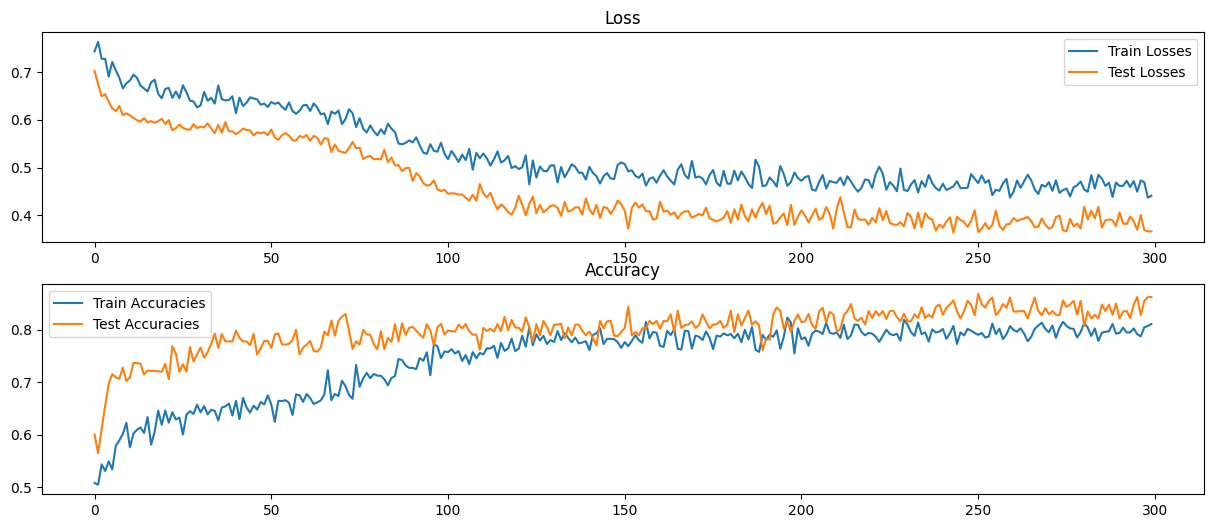

In [139]:
plot_metrics(metrics)